## Практическое задание

#### 1. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

#### Рассмотрим алгоритм Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition (SPP)

Работа находится по ссылке: https://arxiv.org/pdf/1406.4729.pdf

Любая свёрточная нейронная сеть, применяемая для классификации объектов, структурно легко разделяется на две части. Первая состоит из свёрточных (convolution) и объединяющих (pooling) слоёв (сюда же все нелинейности, LRN, batch normalization и т.п.) и по исходной картинке формирует трёхмерную матрицу особенностей (features). Вторая часть сети является классификатором, который, взяв набор особенностей, выдаёт класс объекта на изображении (вернее вектор sofmax с вероятностями для каждого класса).

Spatial pyramid pooling слой между свёрточной частью и классификатором, который даёт возможность классифицировать изображения произвольных размеров.

Таким образом, основным преимуществом данного алгоритма является то, что в качестве входных можно использовать изображения любого размера без предварительной обработки. При этом алгоритм согласно авторам работы показывает высокую точность и существенно ускоряет DNN-based (Deep Neural Network) определение объектов.

Достоинства алгоритма:
- скорость работы (по утверждению авторов при схожей точности алгоритм гораздо быстрее чем R-CNN);
- возможность подавать на вход  изображения любого размера без предварительной обработки;
- нет нелбходимости повторного вычисления сверточных функций;
- устойчив к деформациям объектов.

Недостатки алгоритма:
- потеря части информации об объекте;
- некоторое усложнение сети.

#### 2. Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

In [1]:
import os
PATH_TO_IMGS = 'pics/'
img_list = os.listdir(PATH_TO_IMGS)

import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

import tensorflow_hub as hub
import tensorflow as tf

from PIL import Image, ImageFont, ImageColor, ImageDraw

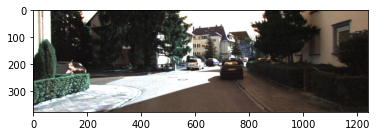

In [2]:
# просмотр пример картинки
img = cv2.imread(PATH_TO_IMGS + img_list[0])

plt.imshow(img)
plt.show()

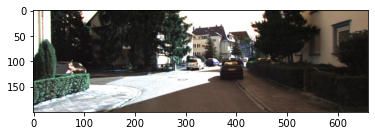

In [3]:
# изменение размера
newH = 200
newW = int(img.shape[1] * newH / img.shape[0])

img = cv2.resize(img, (newW, newH))

plt.imshow(img)
plt.show()

In [4]:
module_handle = {"ssd": "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", 
                 "faster_rcnn": "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"}

detector = hub.load(module_handle['ssd']).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
def load_img(path):

# path - маршрут и имя файла для обработки
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)

# вернет картинку как тензор
    return img

# выводит картинку
def display_image(image):
    fig = plt.figure(figsize=(12, 9))
    plt.imshow(image)

In [6]:
def draw_bounding_box_on_image(image,
                               ymin, xmin,
                               ymax, xmax,
                               color, font,
                               thickness=4,
                               display_str_list=()):
    
  """Adds a bounding box to an image."""

  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.    
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [7]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
    
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())
  font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin, xmin,
          ymax, xmax,
          color, font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [8]:
def run_detector(detector, path, max_boxes):

  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  result = {key: value.numpy() for key, value in result.items()} 

  # max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции 
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_boxes)

  display_image(image_with_boxes)

  return result

In [9]:
import os, fnmatch
pattern = '*.png'
list_name = []
for entry in img_list:
    if fnmatch.fnmatch(entry, pattern):
            list_name.append(np.array(PATH_TO_IMGS + entry))
list_name[0]

array('pics/00_000200.png', dtype='<U18')

Находим 10 объектов (max_boxes=10)

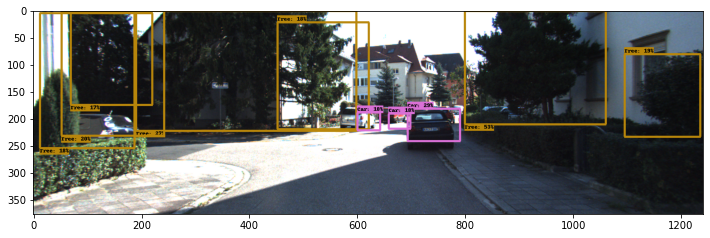

In [10]:
result = run_detector(detector, list_name[0], max_boxes=10)

Находим 100 объектов (max_boxes=100)

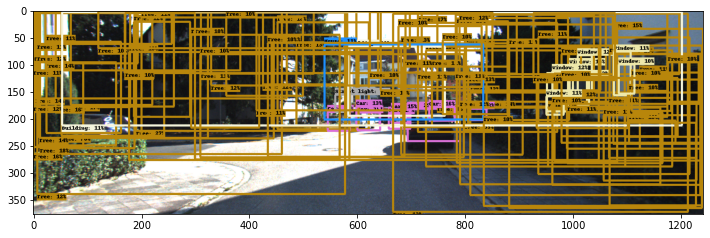

In [11]:
result = run_detector(detector, list_name[0], max_boxes=100)

При 100 объектах на данной картинке что-то понять уже сложно.